In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
from operator import attrgetter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tracker.satellite import Satellite
from tracker.tle import TLE

In [3]:
zarya_tle_archive = None
archive_path = 'tle_files/zarya_2017-2018_tles.txt'

with open(archive_path, 'r') as f_archive:
    zarya_tle_archive = f_archive.read()
    
tle_lines = zarya_tle_archive.split('\n')[:-1]
tles_file = []

for i in range(0, len(tle_lines), 2):
    line1, line2 = tle_lines[i:i + 2]
    tle = TLE(line1, line2)
    tles_file.append(tle)
    
tles_file.sort(key=attrgetter('epoch'))

tles = [tles_file[0]]
for i in range(1, len(tles_file)):
    if tles_file[i].epoch != tles_file[i - 1].epoch:
        tles.append(tles_file[i])

In [4]:
def degrees_error(deg1, deg2):
    err = abs(deg1 - deg2)
    if err > 180.0:
        err = 360.0 - err
    return err

def two_tle_error(tle1, tle2):
    OBS_LAT = -15.989620
    OBS_LON = -48.044411
    OBS_ALT = 500 # meters
    
    sat1 = Satellite(*tle1.tle)
    sat2 = Satellite(*tle2.tle)
    
    epoch1 = tle1.epoch
    epoch2 = tle2.epoch
    
    az1, el1 = sat1.get_observer_azimuth_elevation(OBS_LAT, OBS_LON, OBS_ALT, date=epoch2)
    az2, el2 = sat2.get_observer_azimuth_elevation(OBS_LAT, OBS_LON, OBS_ALT, date=epoch2)
    
    return degrees_error(az1, az2), degrees_error(el1, el2), epoch2 - epoch1

In [5]:
errors = [two_tle_error(tles[i - 1], tles[i]) for i in range(1, len(tles))]
az_errors = np.array([err[0] for err in errors])
el_errors = np.array([err[1] for err in errors])
date_delta_hours = np.array([err[2].total_seconds() / 3600.0 for err in errors])

In [6]:
error_table = pd.DataFrame(
    {'Azimuth error (degrees)': az_errors,
     'Elevation error (degrees)': el_errors,
     'Date delta (hours)': date_delta_hours})

display(error_table.head())

,Azimuth error (degrees),Elevation error (degrees),Date delta (hours)
0,0.000226,0.000076,1.484166
1,0.001001,0.000265,9.791784
2,0.000639,0.000515,3.198929
3,0.003873,0.000846,7.614045
4,0.000733,0.000231,6.544630


# Estatísticas dos erros e tempo de diferença entre TLE consecutivos

In [7]:
error_table.describe()

,Azimuth error (degrees),Elevation error (degrees),Date delta (hours)
count,2.384000e+03,2.384000e+03,2384.000000
mean,6.630041e-03,3.651522e-03,6.642676
std,4.510786e-02,2.319331e-02,5.688412
min,4.711621e-07,7.977932e-08,0.048717
25%,2.841798e-04,1.733753e-04,3.039320
50%,1.087056e-03,6.093880e-04,5.016516
75%,3.391928e-03,1.747791e-03,7.864274
max,1.332285e+00,5.327182e-01,52.952656


# Plotando os erros

In [8]:
def plot_arr(arr, title, xlabel='Error'):
    fig, ax = plt.subplots(1, 1, dpi=100)
    plt.hist(arr, alpha = 0.5, lw=1, color= 'b', edgecolor='k')
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.title(title)
    plt.ylabel('Number of ocorrencies')
    plt.xlabel(xlabel)
    plt.show()

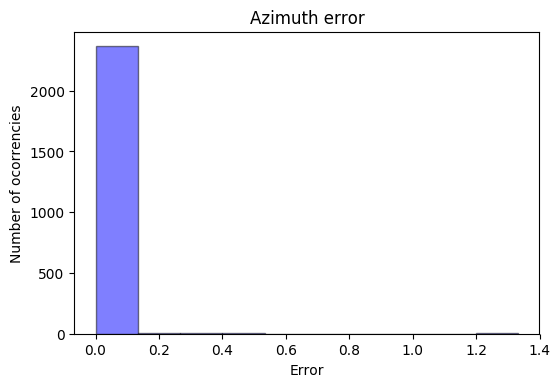

In [9]:
plot_arr(az_errors, 'Azimuth error')

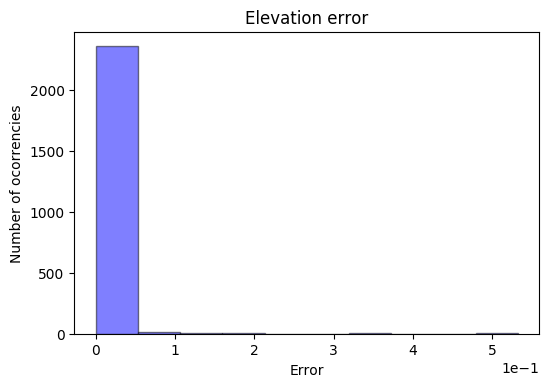

In [10]:
plot_arr(el_errors, 'Elevation error')

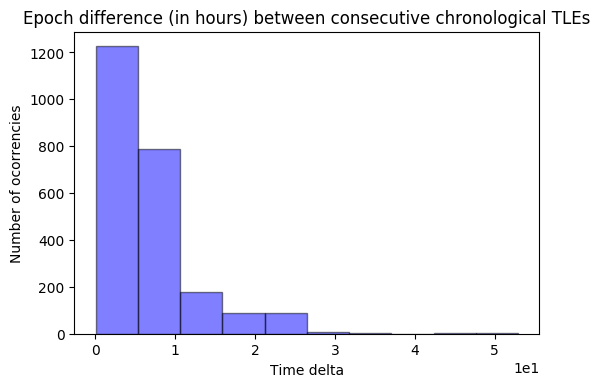

In [11]:
plot_arr(date_delta_hours, 'Epoch difference (in hours) between consecutive chronological TLEs', 'Time delta')

# Calculando erro do TLE em relação a atrasos de TLE

Por exemplo, se estamos considerando um atraso de 3 TLES, então definimos step=3. Caso estejamos interessados num atraso de 15 TLES, então definimos step=15. O erro que estamos interessados é a média dos erros absolutos dos parâmetros azimute e elevação.

In [71]:
def find_delayed_pairs(tles, step):
    az = []
    el = []
    error_count = 0
    for i in range(step, len(tles)):
        j = i - step
        tle1 = tles[i]
        tle2 = tles[j]
        errors = two_tle_error(tle2, tle1)
        time_delta = errors[2].total_seconds()
        az.append(errors[0])
        el.append(errors[1])

        
        
        debug = errors[0] > 0.5 or errors[1] > 0.25
        
        if debug:
            #print('Big error azimuth={}, timedelta={}h, step={}\nTLE1 = {}\nTLE2 = {}\n'.
                  #format(errors[0], time_delta / 3600.0, step, tle2.tle, tle1.tle))
            error_count += 1
        
    if error_count > 0:
            print('Step = {}'.format(step))
            print('Trust percentage = {:.2f}%\n'.format(100 - (error_count * 100.0 / (len(tles) - step))))
            
    assert len(az) == len(el)            
    return az, el

In [72]:
data = dict()

mean_std = lambda x: (np.mean(x), np.std(x), np.min(x), np.max(x))

steps = [1, 5, 10, 20]

for i in steps:
    az, el = find_delayed_pairs(tles, i)
    data['Erro absoluto azimute (atraso TLE={})'.format(i)] = mean_std(az)
    data['Erro absoluto elevação (atraso TLE={})'.format(i)] = mean_std(el)

df = pd.DataFrame(data, index=['Média', 'Desvio', 'Min', 'Max']).transpose()
display(df)

Step = 1
Trust percentage = 99.66%

Step = 5
Trust percentage = 96.39%

Step = 10
Trust percentage = 89.89%

Step = 20
Trust percentage = 76.32%



,Média,Desvio,Min,Max
Erro absoluto azimute (atraso TLE=1),0.006630,0.045098,4.711621e-07,1.332285
Erro absoluto elevação (atraso TLE=1),0.003652,0.023188,7.977932e-08,0.532718
Erro absoluto azimute (atraso TLE=5),0.073809,0.841014,1.051637e-06,36.321273
Erro absoluto elevação (atraso TLE=5),0.034663,0.183456,3.714125e-06,4.934663
Erro absoluto azimute (atraso TLE=10),0.247526,2.768740,7.121997e-06,127.878937
Erro absoluto elevação (atraso TLE=10),0.121756,0.919533,4.787525e-06,37.818818
Erro absoluto azimute (atraso TLE=20),0.738540,4.421782,9.365807e-06,169.970111
Erro absoluto elevação (atraso TLE=20),0.382402,1.557602,3.777066e-06,31.280350


In [62]:
def see_erro(tle1, tle2):
    OBS_LAT = -15.989620
    OBS_LON = -48.044411
    OBS_ALT = 500 # meters

    sat1 = Satellite(*tle1.tle)
    sat2 = Satellite(*tle2.tle)
    
    az1, el1 = sat1.get_observer_azimuth_elevation(OBS_LAT, OBS_LON, OBS_ALT, date=tle2.epoch)
    az2, el2 = sat2.get_observer_azimuth_elevation(OBS_LAT, OBS_LON, OBS_ALT, date=tle2.epoch)
    
    print('OBS_LAT = {}'.format(OBS_LAT))
    print('OBS_LON = {}'.format(OBS_LON))
    print('OBS_ALT = {}\n'.format(OBS_ALT))
    print('date = {}\n'.format(tle2.epoch))
    print('azimuth1 = {}'.format(az1))
    print('elevation1 = {}'.format(el1))
    print('azimuth2 = {}'.format(az2))
    print('elevation2 = {}\n'.format(el2))
    print('error_az = {}'.format(abs(az1 - az2)))
    print('error_el = {}\n'.format(abs(el1 - el2)))
    print('epoch1 = {}'.format(tle1.epoch))
    print('epoch2 = {}\n'.format(tle2.epoch))
    return az1, el1, tle2.epoch

TLE1 = TLE('1 25544U 98067A   17093.89997377 -.00374146 +00000-0 -59469-2 0  9991', '2 25544 051.6388 048.5881 0008452 007.5935 049.0372 15.53922235050204')
TLE2 = TLE('1 25544U 98067A   17098.86053830 +.00003442 +00000-0 +59411-4 0  9995', '2 25544 051.6434 023.8590 0006670 038.3011 068.5407 15.54042428050973')

print('TLE1 = {}'.format(TLE1.tle))
print('TLE2 = {}\n'.format(TLE2.tle))

see_erro(TLE1, TLE2)

TLE1 = ('1 25544U 98067A   17093.89997377 -.00374146 +00000-0 -59469-2 0  9991', '2 25544 051.6388 048.5881 0008452 007.5935 049.0372 15.53922235050204')
TLE2 = ('1 25544U 98067A   17098.86053830 +.00003442 +00000-0 +59411-4 0  9995', '2 25544 051.6434 023.8590 0006670 038.3011 068.5407 15.54042428050973')

OBS_LAT = -15.98962
OBS_LON = -48.044411
OBS_ALT = 500

date = 2017-04-08 20:39:10.509120+00:00

azimuth1 = 350.5168011481939
elevation1 = -29.870727668914974
azimuth2 = 26.838073868268403
elevation2 = -34.8053907017635

error_az = 323.6787272799255
error_el = 4.934663032848526

epoch1 = 2017-04-03 21:35:57.733728+00:00
epoch2 = 2017-04-08 20:39:10.509120+00:00



(350.5168011481939,
 -29.870727668914974,
 datetime.datetime(2017, 4, 8, 20, 39, 10, 509120, tzinfo=datetime.timezone.utc))